In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'


# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)


from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *


## Generate a fixed delta function input signal

Text(0.5, 1.0, 'output signal')

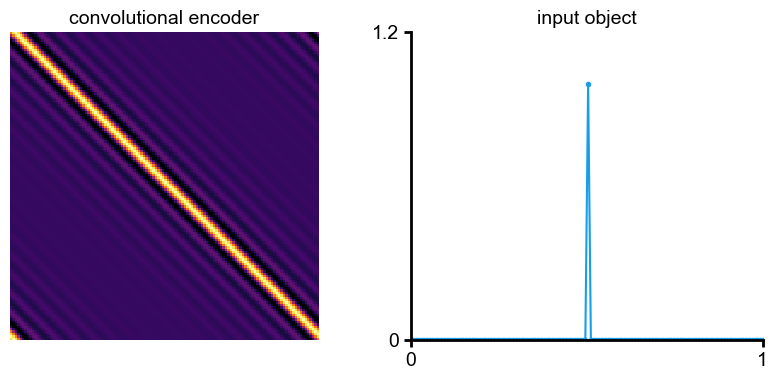

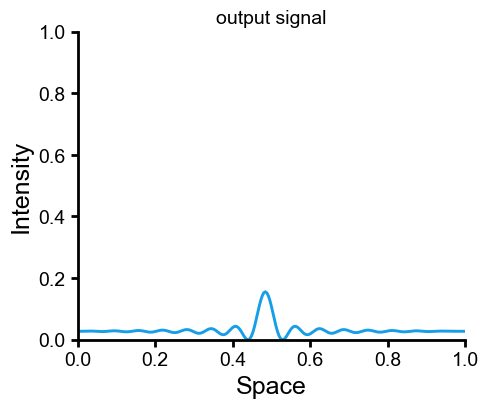

In [26]:
# signal = generate_random_1_over_f_signal(num_non_dc_in_bandlimit= 10)
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function
# input_signal = bandlimited_nonnegative_signal(delta_function)


# generate the convolutional encoder
nyquist_samples = onp.zeros(NUM_NYQUIST_SAMPLES)
nyquist_samples[-1] = 1
kernel = bandlimited_nonnegative_signal(nyquist_samples=np.array(nyquist_samples))

conv_mat = make_convolutional_encoder(kernel)
conv_mat_for_display = make_convolutional_encoder(kernel, sample=False)

# plot the input signal
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(conv_mat_for_display, cmap='inferno', interpolation='none')
ax[0].set_title('convolutional encoder')
# remove axes
ax[0].axis('off')


ax[1].plot(np.linspace(0,1, input_signal.size), input_signal,  '.-', label='input signal',)
ax[1].set_title('input object')
ax[1].set(xlim=(0,1))
default_format(ax[1])


# do the convolution
output_signal = conv_mat @ input_signal
# plot the output signal
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_spatial_coordinates(ax, output_signal, label='output signal')
ax.set_title('output signal')

## Optimize the convolution matrix to map a delta towards a target signal

initial loss 0.026705675


Array(0.5797328, dtype=float32)

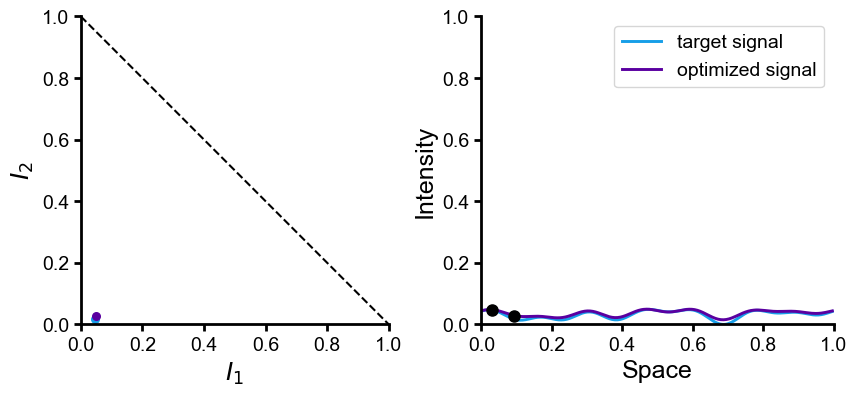

In [5]:

# generate a delta function target signal (cant be achieved because of bandlimit)
use_sampling_indices = False
sampling_indices = (0, 1)
norm_energy = True
# num_nyquist_samples = NUM_NYQUIST_SAMPLES
# num_nyquist_samples = NUM_NYQUIST_SAMPLES // 2
num_nyquist_samples = 16

delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function

# target_signal = onp.zeros_like(generate_concentrated_signal(sampling_indices, num_nyquist_samples=num_nyquist_samples))
# # target_signal[sampling_indices[0]] = 1
# target_signal[sampling_indices[0]] = 0.5
# target_signal[sampling_indices[1]] = 0.5
# target_signal = np.array(target_signal)
# # target_signal = bandlimited_nonnegative_signal(target_signal)

target_signal = generate_random_bandlimited_signal(num_nyquist_samples=num_nyquist_samples, seed=1234456)
# print(target_signal.sum())

# nyquist_samples = onp.zeros(num_nyquist_samples)
# nyquist_samples[0] = 1
# nyquist_samples[1] = 0.5
# nyquist_samples[2:] = 0
# target_signal = bandlimited_nonnegative_signal(nyquist_samples, num_nyquist_samples=num_nyquist_samples)

initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal(num_nyquist_samples=num_nyquist_samples), 
                                                num_nyquist_samples=num_nyquist_samples)

loss_fn = make_convolutional_forward_model_and_target_signal_MSE_loss_fn(input_signal, target_signal, 
                                                       sampling_indices=sampling_indices if use_sampling_indices else None)
optimized_params = run_optimzation(loss_fn, lambda x : signal_prox_fn(x, num_nyquist_samples=num_nyquist_samples), 
                         params_from_signal(initial_kernel, num_nyquist_samples=num_nyquist_samples), learning_rate=1e-3, verbose=True)

optimized_kernel = signal_from_params(optimized_params, num_nyquist_samples=num_nyquist_samples)

# make the convolutional encoder from the optimized kernel
optimized_conv_mat = make_convolutional_encoder(optimized_kernel, num_nyquist_samples=num_nyquist_samples)
initial_conv_mat = make_convolutional_encoder(initial_kernel, num_nyquist_samples=num_nyquist_samples)
optimized_signal = optimized_conv_mat @ input_signal
initial_signal = initial_conv_mat @ input_signal

# plot target and optimized signal in intensity and spatial coordinates
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_in_intensity_coordinates(ax[0], target_signal, label='target signal', sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax[0], optimized_signal, label='optimized signal', sample_point_indices=sampling_indices)

plot_in_spatial_coordinates(ax[1], target_signal, label='target signal', sample_point_indices=sampling_indices)
plot_in_spatial_coordinates(ax[1], optimized_signal, label='optimized signal', sample_point_indices=sampling_indices, show_samples=True)
ax[1].legend()

optimized_signal.sum()

## Make a grid of points to use as loss function targets

  0%|          | 0/34 [00:00<?, ?it/s]

initial loss 0.0042391694


  3%|▎         | 1/34 [00:14<07:42, 14.02s/it]

initial loss 0.0061751097


  6%|▌         | 2/34 [00:31<08:30, 15.94s/it]

initial loss 0.04892738


  9%|▉         | 3/34 [00:53<09:46, 18.93s/it]

initial loss 0.13249598


 12%|█▏        | 4/34 [01:40<14:59, 29.98s/it]

initial loss 0.2568809


 15%|█▍        | 5/34 [02:41<19:49, 41.00s/it]

initial loss 0.42208213


 18%|█▊        | 6/34 [03:47<23:08, 49.59s/it]

initial loss 0.6280998


 21%|██        | 7/34 [04:51<24:28, 54.41s/it]

initial loss 0.8749336


 24%|██▎       | 8/34 [05:55<24:54, 57.47s/it]

initial loss 0.022449251


 26%|██▋       | 9/34 [06:20<19:39, 47.17s/it]

initial loss 0.024385192


 29%|██▉       | 10/34 [06:34<14:44, 36.85s/it]

initial loss 0.067137465


 32%|███▏      | 11/34 [06:53<12:06, 31.60s/it]

initial loss 0.15070607


 35%|███▌      | 12/34 [07:13<10:15, 27.98s/it]

initial loss 0.275091


 38%|███▊      | 13/34 [08:04<12:16, 35.07s/it]

initial loss 0.4402922


 41%|████      | 14/34 [09:09<14:38, 43.93s/it]

initial loss 0.08147567


 44%|████▍     | 15/34 [09:48<13:24, 42.37s/it]

initial loss 0.083411604


 47%|████▋     | 16/34 [10:07<10:39, 35.54s/it]

initial loss 0.12616387


 50%|█████     | 17/34 [10:21<08:12, 28.96s/it]

initial loss 0.20973247


 53%|█████▎    | 18/34 [10:40<06:58, 26.13s/it]

initial loss 0.3341174


 56%|█████▌    | 19/34 [11:32<08:26, 33.76s/it]

initial loss 0.49931863


 59%|█████▉    | 20/34 [12:36<10:01, 42.96s/it]

initial loss 0.18131842


 62%|██████▏   | 21/34 [12:55<07:43, 35.68s/it]

initial loss 0.18325436


 65%|██████▍   | 22/34 [13:21<06:34, 32.87s/it]

initial loss 0.22600663


 68%|██████▊   | 23/34 [13:41<05:17, 28.89s/it]

initial loss 0.30957523


 71%|███████   | 24/34 [14:26<05:38, 33.85s/it]

initial loss 0.43396014


 74%|███████▎  | 25/34 [15:31<06:27, 43.04s/it]

initial loss 0.32197747


 76%|███████▋  | 26/34 [16:03<05:16, 39.61s/it]

initial loss 0.3239134


 79%|███████▉  | 27/34 [16:54<05:02, 43.23s/it]

initial loss 0.36666566


 82%|████████▏ | 28/34 [17:54<04:48, 48.05s/it]

initial loss 0.4502343


 85%|████████▌ | 29/34 [18:59<04:26, 53.36s/it]

initial loss 0.50345284


 88%|████████▊ | 30/34 [20:05<03:48, 57.18s/it]

initial loss 0.5053888


 91%|█████████ | 31/34 [21:11<02:59, 59.81s/it]

initial loss 0.54814106


 94%|█████████▍| 32/34 [22:17<02:03, 61.70s/it]

initial loss 0.72574466


 97%|█████████▋| 33/34 [23:24<01:03, 63.20s/it]

initial loss 0.98885256


100%|██████████| 34/34 [24:30<00:00, 43.26s/it]

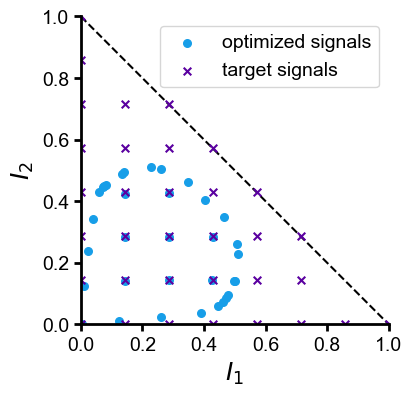

In [6]:
num_nyquist_samples = NUM_NYQUIST_SAMPLES
sampling_indices = (0, 1)
num_grid_points = 8
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
object = delta_function

target_signals = make_intensity_coordinate_sampling_grid(sampling_indices, sample_n=num_grid_points, num_nyquist_samples=num_nyquist_samples)
# target_signals = np.array([target_signal])
optimized_kernels, output_signals = optimize_towards_target_signals(target_signals, object,
                                                                    sampling_indices=sampling_indices,
                                                                    verbose=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_intensity_coordinates(ax, output_signals, label='optimized signals',  sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax, target_signals, label='target signals',  marker='x',  sample_point_indices=sampling_indices)
ax.legend()

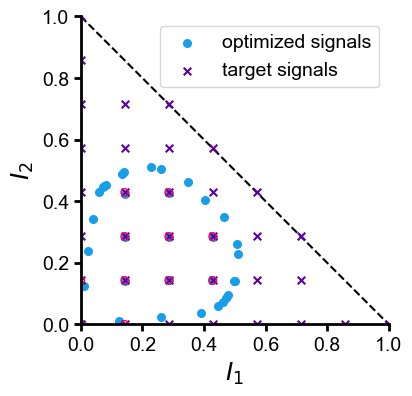

In [8]:
# compute L2 distance between target and output signals
dist = np.sqrt(np.sum((target_signals[:, sampling_indices] - output_signals[:, sampling_indices]) ** 2, axis=1))
threshold = 0.03

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_intensity_coordinates(ax, output_signals, label='optimized signals',  sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax, target_signals, label='target signals',  marker='x',  sample_point_indices=sampling_indices)

# plot open circles on all the ones that have a distance below a threshold
plot_in_intensity_coordinates(ax, target_signals[dist < threshold], 
                               sample_point_indices=sampling_indices, marker='o', color='none', edgecolor=get_color_cycle()[2])
ax.legend()

## Plot the randomly generated signals

num positive targets: 3000


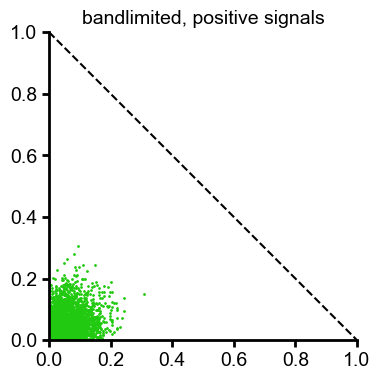

In [42]:
num_nyquist_samples = 16

# load  samples

positive_targets = np.load('.cache/{}_dimensional_random_bandlimited_positive_samples.npy'.format(num_nyquist_samples), allow_pickle=True)
print('num positive targets: {}'.format(len(positive_targets)))

# now scatter only the positive targets
positive_targets = np.array(positive_targets)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(positive_targets[:, 0], positive_targets[:, 1], s=1, color=get_color_cycle()[3])
# plot dashed line for the L1 ball
ax.plot(np.linspace(0, 1, 100), 1 - np.abs(np.linspace(0, 1, 100)), '--', color='k')
# square axes
ax.set_aspect('equal', 'box')
clear_spines(ax)
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.title.set_text('bandlimited, positive signals')

In [43]:
print(np.unique(positive_targets, axis=0).shape,
        positive_targets.shape)

(3000, 16) (3000, 16)


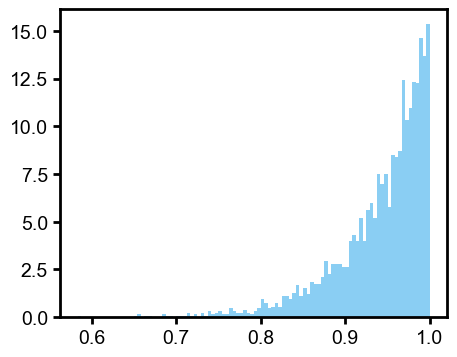

In [44]:
mags_pos = np.sum(positive_targets, axis=1)

# plot hist
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
_ = ax.hist(mags_pos, bins=100, alpha=0.5, label='positive target signal', density=True)

## Compare entropy to uniform entropy

In [47]:
def compute_mutual_information_for_optimized_encoder(num_nyquist_samples, noise_sigma, key):
    N_objects = 2000
    objects_fn = lambda : np.array([sample_amplitude_object('delta', num_deltas=1) for i in range(N_objects)])

    initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal(num_nyquist_samples=num_nyquist_samples), num_nyquist_samples=num_nyquist_samples) 
    initial_params = params_from_signal(initial_kernel, num_nyquist_samples=num_nyquist_samples)
    loss_fn = make_convolutional_forward_model_with_mi_loss(objects_fn(), noise_sigma, num_nyquist_samples=num_nyquist_samples)
    optimized_params = run_optimzation(loss_fn, lambda x : signal_prox_fn(x, num_nyquist_samples=num_nyquist_samples), 
                            initial_params,
                              learning_rate=1e-2, learning_rate_decay=0.999,
                              verbose=True,
                            loss_improvement_patience=2000, max_epochs=5000, key=key)

    output_signals = conv_forward_model(optimized_params, objects_fn(), num_nyquist_samples=num_nyquist_samples)

    key, subkey = jax.random.split(key)
    noisy_output_signals = output_signals + noise_sigma * jax.random.normal(subkey, output_signals.shape)

    mi = compute_mutual_information_per_pixel(noisy_output_signals=noisy_output_signals, noise_sigma=noise_sigma,)
    return mi, subkey

def compute_uniform_samples_mi(num_nyquist_samples, noise_sigma, key):

    l1_ball_samples = np.load(".cache/{}_dimensional_random_bandlimited_positive_samples.npy".format(num_nyquist_samples), allow_pickle=True)
    l1_ball_samples = np.array(l1_ball_samples)

    uniformly_sampled_signals = filter_l1_ball_samples_to_positive(l1_ball_samples)
    print(f'{num_nyquist_samples} nyquist num valid samples ', uniformly_sampled_signals.shape[0])

    noisy_signals = uniformly_sampled_signals + noise_sigma * jax.random.normal(key, uniformly_sampled_signals.shape)

    uniform_mi = compute_mutual_information_per_pixel(noisy_output_signals=noisy_signals, noise_sigma=noise_sigma,)
    return uniform_mi




In [48]:
num_nyquist_samples_list = onp.arange(2, 34, 2)
key = jax.random.PRNGKey(0)
noise_sigma = 1e-4


mi_list = []
mi_uniform_list = []
for num_nyquist_samples in tqdm(num_nyquist_samples_list):
    mi, key = compute_mutual_information_for_optimized_encoder(num_nyquist_samples, noise_sigma, key)
    mi_list.append(mi)
    _, key = jax.random.split(key)
    mi_uniform = compute_uniform_samples_mi(num_nyquist_samples, noise_sigma, key)
    _, key = jax.random.split(key)
    mi_uniform_list.append(mi_uniform)


  0%|          | 0/16 [00:00<?, ?it/s]

initial loss -5.973945640586902


100%|██████████| 3000/3000 [00:03<00:00, 926.46it/s]


2 nyquist num valid samples  3000


  6%|▋         | 1/16 [01:15<18:54, 75.66s/it]

initial loss -7.2156906830940315


100%|██████████| 3000/3000 [00:02<00:00, 1437.89it/s]


4 nyquist num valid samples  3000


 12%|█▎        | 2/16 [01:55<12:40, 54.30s/it]

initial loss -7.109722249768831


100%|██████████| 3000/3000 [00:03<00:00, 994.01it/s] 


6 nyquist num valid samples  3000


 19%|█▉        | 3/16 [03:14<14:15, 65.81s/it]

initial loss -7.739280062762446


100%|██████████| 3000/3000 [00:03<00:00, 950.07it/s] 


8 nyquist num valid samples  3000


 25%|██▌       | 4/16 [04:32<14:07, 70.61s/it]

initial loss -7.666903598291592


100%|██████████| 3000/3000 [00:03<00:00, 944.14it/s]


10 nyquist num valid samples  3000


 31%|███▏      | 5/16 [05:53<13:37, 74.31s/it]

initial loss -7.665118549610658


100%|██████████| 3000/3000 [00:03<00:00, 949.99it/s]


12 nyquist num valid samples  3000


 38%|███▊      | 6/16 [06:44<11:04, 66.48s/it]

initial loss -7.31360985398007


100%|██████████| 3000/3000 [00:03<00:00, 962.24it/s] 


14 nyquist num valid samples  3000


 44%|████▍     | 7/16 [08:06<10:42, 71.41s/it]

initial loss -7.010879334167738


100%|██████████| 3000/3000 [00:03<00:00, 879.77it/s]


16 nyquist num valid samples  3000


 50%|█████     | 8/16 [09:38<10:25, 78.16s/it]

initial loss -6.856856705257342


100%|██████████| 3000/3000 [00:03<00:00, 773.83it/s] 


18 nyquist num valid samples  3000


 56%|█████▋    | 9/16 [11:06<09:27, 81.10s/it]

initial loss -7.2556630763961


100%|██████████| 3000/3000 [00:03<00:00, 769.31it/s] 


20 nyquist num valid samples  3000


 62%|██████▎   | 10/16 [12:34<08:19, 83.32s/it]

initial loss -7.041823635169134


100%|██████████| 3000/3000 [00:04<00:00, 735.52it/s]


22 nyquist num valid samples  3000


 69%|██████▉   | 11/16 [14:03<07:04, 85.00s/it]

initial loss -6.89073937660945


100%|██████████| 3000/3000 [00:03<00:00, 802.69it/s]


24 nyquist num valid samples  3000


 75%|███████▌  | 12/16 [15:34<05:47, 86.91s/it]

initial loss -6.715768984571196


100%|██████████| 3000/3000 [00:03<00:00, 822.42it/s] 


26 nyquist num valid samples  3000


 81%|████████▏ | 13/16 [17:04<04:23, 87.71s/it]

initial loss -6.805434292502981


100%|██████████| 3000/3000 [00:02<00:00, 1382.30it/s]


28 nyquist num valid samples  3000


 88%|████████▊ | 14/16 [18:32<02:55, 87.75s/it]

initial loss -6.777761946345087


100%|██████████| 3000/3000 [00:02<00:00, 1354.05it/s]


30 nyquist num valid samples  3000


 94%|█████████▍| 15/16 [19:32<01:19, 79.60s/it]

initial loss -6.499871587617205


100%|██████████| 3000/3000 [00:02<00:00, 1382.57it/s]


32 nyquist num valid samples  3000


100%|██████████| 16/16 [20:34<00:00, 77.17s/it]


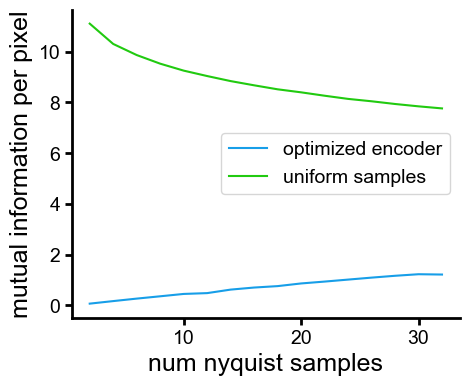

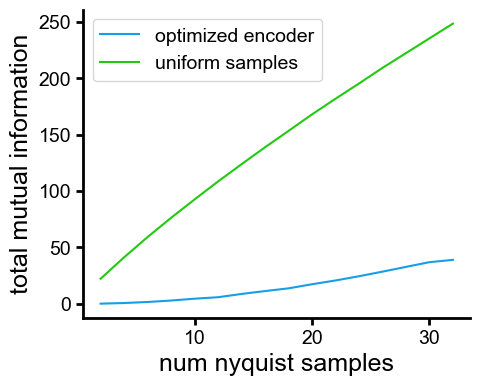

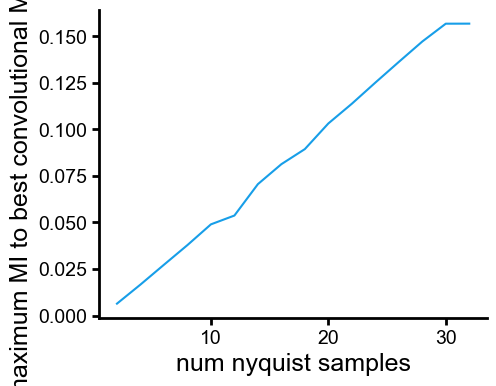

In [49]:
# convert everything to numpy
mi_list = np.array(mi_list)
mi_uniform_list = np.array(mi_uniform_list)
num_nyquist_samples_list = np.array(num_nyquist_samples_list)
total_mi_conv = mi_list * num_nyquist_samples_list
total_mi_uniform = mi_uniform_list * num_nyquist_samples_list


# plot them both
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(num_nyquist_samples_list, mi_list, label='optimized encoder')
ax.plot(num_nyquist_samples_list, mi_uniform_list, label='uniform samples', color=get_color_cycle()[3])
ax.set(xlabel='num nyquist samples', ylabel='mutual information per pixel')
clear_spines(ax)
ax.legend()

# plot toal mi
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(num_nyquist_samples_list, total_mi_conv, label='optimized encoder')
ax.plot(num_nyquist_samples_list, total_mi_uniform, label='uniform samples', color=get_color_cycle()[3])
ax.set(xlabel='num nyquist samples', ylabel='total mutual information')
clear_spines(ax)
ax.legend()


# plot the fraction
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(num_nyquist_samples_list, mi_list / mi_uniform_list, label='optimized encoder')
ax.set(xlabel='num nyquist samples', ylabel='maximum MI to best convolutional MI ratio')
clear_spines(ax)
